# About this dataset
Link https://www.kaggle.com/datasets/andrewmvd/trip-advisor-hotel-reviews


Hotels play a crucial role in traveling and with the increased access to information new pathways of selecting the best ones emerged.
With this dataset, consisting of 20k reviews crawled from Tripadvisor, you can explore what makes a great hotel and maybe even use this model in your travels!

###Imports

In [4]:
import pandas as pd
import numpy as np
import tensorflow as tf
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords

### Load the Datasets

In [5]:
df = pd.read_csv("tripadvisor_hotel_reviews.csv", engine='python', quotechar='"', doublequote=True, on_bad_lines='skip')
df.head()

,Review,Rating
0,nice hotel expensive parking got good deal sta...,4
1,ok nothing special charge diamond member hilto...,2
2,nice rooms not 4* experience hotel monaco seat...,3
3,"unique, great stay, wonderful time hotel monac...",5
4,"great stay great stay, went seahawk game aweso...",5


### Explore the data

In [6]:
df.isnull().sum()

,0
Review,0
Rating,0


In [7]:
df.duplicated().sum()

np.int64(18752)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39256 entries, 0 to 39255
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Review  39256 non-null  object
 1   Rating  39256 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 613.5+ KB


###Processing the text

In [9]:
# withe the help of this you can see the common words that are not that useful to our model its just consume the computation

import nltk
nltk.download('stopwords')
Useless_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [10]:
# fuction to remove those words

def Process_text(text):
  text = re.sub(r'\d+', '', text) # Corrected line
  text = text.split()
  text = " ".join([word for word in text if word.lower().strip() not in Useless_words])
  return text

In [11]:
review =  df["Review"].apply(Process_text)

In [12]:
num_words= 10000
tokenizer = Tokenizer(
                       num_words=num_words

)


tokenizer.fit_on_texts(review)

In [13]:
sequences = tokenizer.texts_to_sequences(review)

In [14]:
max_seq_length = np.max(list(map(lambda x: len(x), sequences)))

print("Max sequence length:", max_seq_length)

Max sequence length: 1831


In [15]:
x = pad_sequences(sequences, maxlen=max_seq_length, padding='post')

In [16]:
x

array([[   8,    1,  172, ...,    0,    0,    0],
       [ 138,  136,  266, ...,    0,    0,    0],
       [   8,    9,   76, ...,    0,    0,    0],
       ...,
       [ 138,  735,    8, ...,    0,    0,    0],
       [   1, 3707, 2532, ...,    0,    0,    0],
       [  26, 1159,  190, ...,    0,    0,    0]], dtype=int32)

###Encoding Labels

In [17]:
df["Rating"].value_counts()

,count
Rating,
5,17402
4,11587
3,4159
2,3422
1,2686


In [18]:
""" now here the rating goes in between 1 to 5 its you decision to put better threshold according to your model
I am taking 4 and 5 both as true """

y = np.array(df['Rating'].apply(lambda x : 1 if x >= 4 else 0 ))

###Spliting

In [19]:
x_train,x_test,y_train,y_test = train_test_split(
                                                    x,y,
                                                    test_size=0.7,
                                                    random_state=42
)

###Model Training  With RNN


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


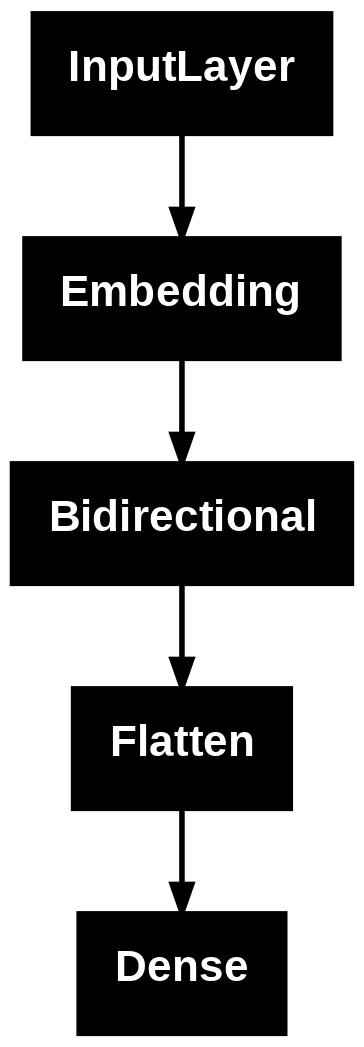

In [20]:
embedding_dim = 128

x = tf.keras.Input(shape=(max_seq_length,))

embedding = tf.keras.layers.Embedding(
    input_dim=num_words,
    output_dim=embedding_dim,
    input_length=max_seq_length
)(x)

gru = tf.keras.layers.Bidirectional(
    tf.keras.layers.GRU(128, return_sequences=True)
)(embedding)

flatten = tf.keras.layers.Flatten()(gru)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(flatten)


model = tf.keras.Model(x, outputs)

tf.keras.utils.plot_model(model)

In [21]:
model.compile(

              optimizer = 'adam',
              loss = "binary_crossentropy",
              metrics = [
                  'accuracy',
                  tf.keras.metrics.AUC(name='auc')
              ]
)

history = model.fit(
    x_train,
    y_train,
    validation_split=0.2,
    batch_size=32,
    epochs=20,
    callbacks=[
            tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=2,
            restore_best_weights=True
            )
    ]
)

Epoch 1/20
295/295 ━━━━━━━━━━━━━━━━━━━━ 45s 134ms/step - accuracy: 0.7218 - auc: 0.6920 - loss: 1.1967 - val_accuracy: 0.9024 - val_auc: 0.9509 - val_loss: 0.2398
Epoch 2/20
295/295 ━━━━━━━━━━━━━━━━━━━━ 78s 131ms/step - accuracy: 0.9453 - auc: 0.9812 - loss: 0.1489 - val_accuracy: 0.8879 - val_auc: 0.9398 - val_loss: 0.3142
Epoch 3/20
295/295 ━━━━━━━━━━━━━━━━━━━━ 43s 137ms/step - accuracy: 0.9828 - auc: 0.9979 - loss: 0.0587 - val_accuracy: 0.8879 - val_auc: 0.9537 - val_loss: 0.3295


###Results

In [23]:
model.evaluate(x_test, y_test)

859/859 ━━━━━━━━━━━━━━━━━━━━ 42s 49ms/step - accuracy: 0.9041 - auc: 0.9500 - loss: 0.2391


[0.24423395097255707, 0.9030567407608032, 0.9471983909606934]